# Project I: Spam detection

# 1. Loading Data

In [ ]:
!pip install --upgrade keras

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import spacy
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (
    LSTM,
    Embedding,  # Changed this line
    BatchNormalization,
    Dense,
    TimeDistributed,
    Dropout,
    Bidirectional,
    Flatten,
    GlobalMaxPool1D
)
from tensorflow.keras.preprocessing.text import Tokenizer  # Changed this line
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Changed this line
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)


In [ ]:
# read file in colab
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
df = pd.read_csv('spam.csv', encoding = 'latin-1')
df = df.dropna(how='any', axis=1)
# This line removes columns from the DataFrame that contain any missing values (NaN).
# how='any' means that if any value in a column is NaN, the entire column will be dropped.
# axis=1 specifies that the operation should be performed on columns rather than rows.

df.columns = ['target', 'message']
# Renaming Columns:

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# This line of code you've provided adds a new column to the DataFrame df called message_len, which calculates the length of each message in terms of the number of words.
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()


,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [ ]:
max(df['message_len'])

171

# 2. EDA (Exploratory Data Analysis)

Checking label balance

In [ ]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [ ]:
# ham: Not spam
import plotly.graph_objects as go

labels = ['ham', 'spam']
fig = go.Figure(data=[go.Pie(labels=labels, values=balance_counts)])
fig.show()

In [ ]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

#plot a graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=ham_df.index, y=ham_df.values, mode='lines+markers', name='ham'))
fig.add_trace(go.Scatter(x=spam_df.index, y=spam_df.values, mode='lines+markers', name='spam'))

fig.update_xaxes(range=[0, 70])
fig.show()


We observe that spams have higher message length

# 3. Data Pre-processing

## 3.1 - Corpus cleaning

In [ ]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    # onverts the input text to lowercase to standardize the text and ensure case insensitivity.

    text = re.sub('\[.*?\]', '', text)
    # Removes any text inside square brackets ([...]), including the brackets themselves.

    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Removes URLs starting with http://, https://, or www..

    text = re.sub('<.*?>+', '', text)
    # Removes HTML tags (anything between < and >)

    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Removes all punctuation characters from the text.

    text = re.sub('\n', '', text)
    # Removes newline characters.

    text = re.sub('\w*\d\w*', '', text)
    # Removes words that contain numbers (e.g., "word123" will be removed).

    return text

df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


**Stop Words**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


## 3.2 - Stemming

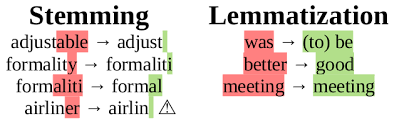

In [ ]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## 3.3 - All Together

In [ ]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## 3.4 - Target (Label) Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


# 4. Tokens Visualization

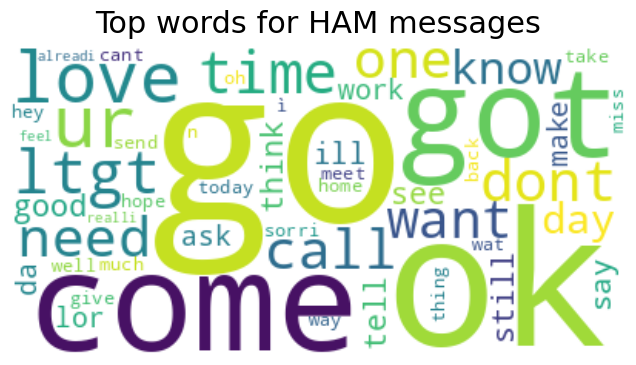

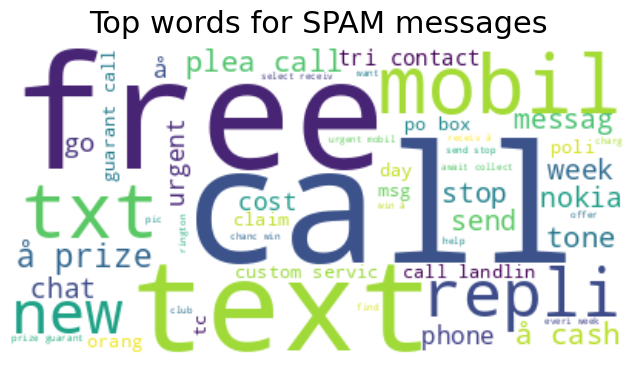

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud for HAM messages
wc = WordCloud(
    background_color='white',
    max_words=50
)

# Generate the word cloud from HAM message text
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))

# Plot the word cloud
plt.figure(figsize=(8,4))
plt.title('Top words for HAM messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))

plt.figure(figsize=(8,4))
plt.title('Top words for SPAM messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

# 5. Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

In [ ]:
x = df['message_clean']
y = df['target_encoded']
print(len(x), len(y))

5572 5572


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


## 5.1 - Count Vectorizer

Note: When you apply CountVectorizer or TfidfVectorizer directly without manually tokenizing the text, the tokenization is handled internally by these vectorizers. There is no need to explicitly tokenize the text beforehand.

CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

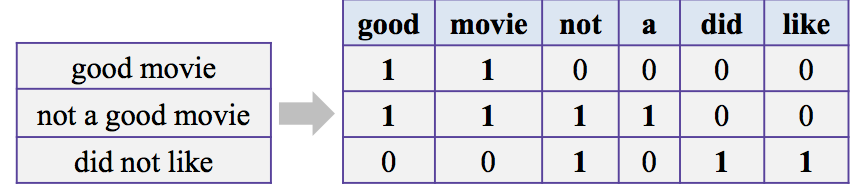

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

CountVectorizer has a few parameters you should know.

1. stop_words: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

2. ngram_range: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1).

3. min_df, max_df: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

4. max_features: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else.

You would set these parameters when initializing your CountVectorizer object as shown below.

In [ ]:
vect_tuned = CountVectorizer(stop_words = 'english', ngram_range=(1,2), min_df = 0.1, max_df=0.7, max_features=100)

## 5.2 - TF-IDF

In information retrieval, tf–idf, TF-IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

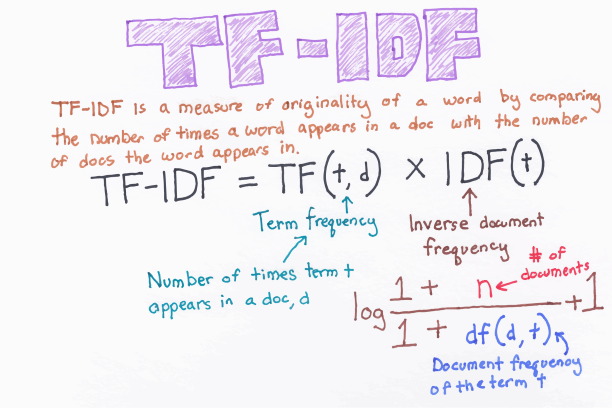

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

## 5.3 - Word Embeddings: GloVe

Thanks to: https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm

In [ ]:
texts = df['message_clean']
target = df['target_encoded']

We need to perform tokenization - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

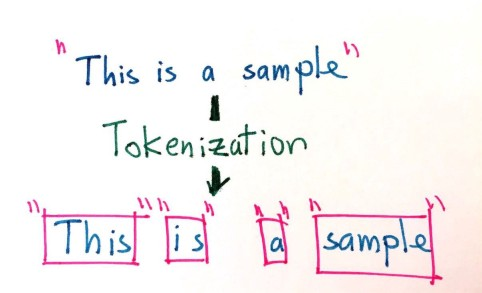

In [ ]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length
# Vocabulary Length: The vocab_length is simply the total number of unique words plus one.
# It is an important number when preparing your text data for input into models like neural networks.
# It represents the size of the vocabulary, or how many distinct words your model will work with.
# This number will be useful when setting up embedding layers or input dimensions for neural networks,
# where you often need to know the number of unique words (the vocabulary size) in your dataset.

6726

In [ ]:
import tensorflow as tf
# Define the 'sequences' variable first
sequences = [
    [1],        # Sequence 1
    [2, 3],     # Sequence 2
    [4, 5, 6]   # Sequence 3
]

# Now use pad_sequences from tf.keras
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)

# Print the padded sequences
print(padded_sequences)

[[0 0 1]
 [0 2 3]
 [4 5 6]]


**Purpose**:

pad_sequences is used to make each sequence in sequences have the same length. This is done by adding (or truncating) values (in this case, zeros) at the beginning (padding='pre').

**Output (padded_sequences):**

After padding, padded_sequences will be a 2D array where each sequence has the same length as the longest sequence in sequences (here, length 3). Shorter sequences are padded with 0

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences


# Download the 'punkt' tokenizer from NLTK
nltk.download('punkt')

def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

**train_padded_sentences**

**Purpose:**

train_padded_sentences is the output where each sentence in the texts corpus is represented as a sequence of numbers (word embeddings), and all sentences are padded to the same length.


**Result:**

Each sentence becomes a vector of numbers with padding to match the length of the longest sentence.

**GloVe**

GloVe method is built on an important idea,

You can derive semantic relationships between words from the co-occurrence matrix.

To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-12 23:47:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-12 23:47:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-12 23:47:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt') as fp:  # Update with your path
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# embeddings_dictionary

GloVe (Global Vectors for Word Representation) is a method that creates word embeddings, which are mathematical representations of words. Here’s how it works, in a nutshell:

1. Word Co-occurrence: GloVe starts by looking at how often words appear together across a large text dataset. If two words (e.g., "king" and "queen") frequently appear in similar contexts, GloVe captures this relationship.

2. Vector Representation: GloVe represents each word as a vector (a list of numbers) in a high-dimensional space. Words with similar meanings have vectors that are close to each other in this space.

3. Semantic Meaning: Because of this design, the distance and direction between vectors represent relationships. For example, the difference between "king" and "queen" is similar to the difference between "man" and "woman."

In short, GloVe uses word co-occurrence patterns to create vectors where similar words have similar representations, making it easier for machines to understand relationships between words.

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# 6. Machine Learning Modelings

## 6.1 - Naive Bayes + Count Vectorizer

MultinomialNB is a specialized version of Naive Bayes for count data, making it particularly useful for text data, where features represent word counts or frequencies.

It assumes each feature follows a multinomial distribution, where features are integer counts (like word occurrences in text).

It is widely used for document classification tasks where feature vectors are counts of terms or words in each document (e.g., in a bag-of-words model).


**When to Use MultinomialNB:**

Use MultinomialNB when working with discrete features, particularly when feature values are non-negative integers (e.g., text classification, with word counts or frequencies).

For continuous data, GaussianNB would be more appropriate, and for binary data, BernoulliNB might be a better fit.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

# to train
nb.fit(x_train_dtm, y_train)

MultinomialNB()

**Key Difference:**

predict() gives you the predicted class labels (either 0 or 1 in a binary classification).
predict_proba() gives you the predicted probabilities for each class. The output is a probability score between 0 and 1, which represents the model's confidence in assigning a particular class to each sample. By using [:, 1], you are specifically getting the probability of the positive class (class 1).


**When to Use Each:**

predict(): When you need to know the final classification decision (e.g., for performance evaluation like accuracy or F1-score).
predict_proba(): When you need more detailed information, such as the probability of the prediction, which can be useful for tasks like decision thresholds, ranking, or ROC curves.

The test accuracy of CTV + NB is: 0.9784637473079684


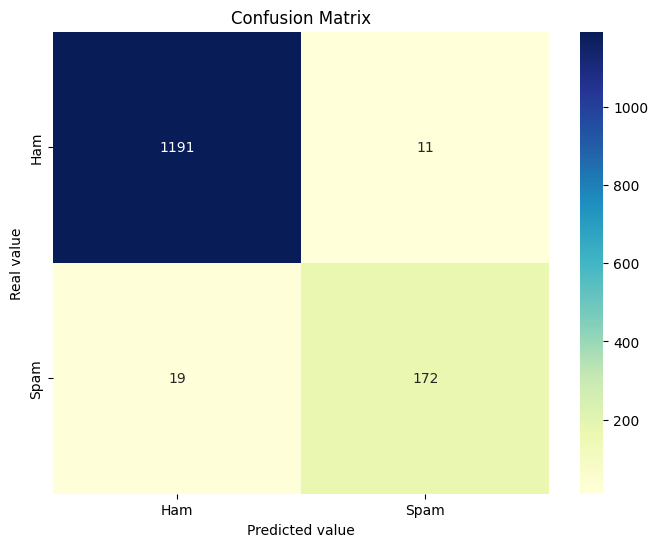

In [ ]:
from sklearn import metrics
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

print('The test accuracy of CTV + NB is:', metrics.accuracy_score(y_test, y_pred_class))

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)

# Create the heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], cbar=True)

# Set the labels and title
plt.xlabel('Predicted value')
plt.ylabel('Real value')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## 6.2 - NB + CTV + TF-IDF

That’s a common assumption! Count Vectorization and TF-IDF are indeed often thought of as alternatives, and they can be used separately, but they can also be combined as in the pipeline you provided. Here’s why they’re used together in some cases:

1. Count Vectorizer as a Base for TF-IDF:

* The Count Vectorizer creates a foundational matrix of raw word counts (bow: bag of words), which is a simple representation of the frequency of words across documents.
* TF-IDF Transformation builds on top of this by adjusting these counts to reflect how important each word is in relation to the entire corpus, effectively converting raw counts into more informative scores.


2. Using Them Together:

* Combining Count Vectorizer with TF-IDF Transformation doesn’t mean you’re using two separate methods for vectorization; rather, you’re layering TF-IDF on top of the BoW model.
* TF-IDF uses the count information as input but adjusts it to de-emphasize common words that aren’t useful for distinguishing between classes, while keeping the structure of the count-based vector space, which is why this approach works well with models like MultinomialNB that expect discrete-like counts.

3. When to Use Separately:

* If you use only the Count Vectorizer, you get raw word frequencies, which can be effective if you’re working with simpler models or with a vocabulary where word importance doesn’t vary much across documents.
* If you use only TF-IDF Vectorization (by applying TfidfVectorizer directly), you skip the intermediate step and get TF-IDF scores in one go, which can be computationally efficient.


So while they’re often seen as alternatives, using both together can, sometimes, improve classification by creating a more nuanced feature representation than raw counts alone. This combination is popular in text classification pipelines, especially with models like Naive Bayes that benefit from the frequency-weighted structure of TF-IDF.

The test accuracy of CTV + Tf-IDF + NB is: 0.9597989949748744


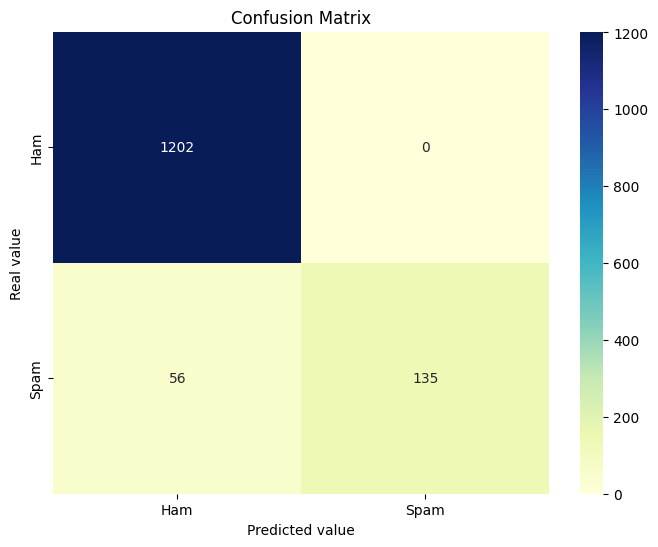

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),# Step 1: Convert text to word frequency (Bag of Words)
                 ('tfidf', TfidfTransformer()),# Step 2: Transform word counts into tf-idf scores
                 ('model', MultinomialNB())])# Step 3: Apply a machine learning model (Naive Bayes)

pipe.fit(x_train, y_train)
y_pred_class = pipe.predict(x_test)
print('The test accuracy of CTV + Tf-IDF + NB is:', metrics.accuracy_score(y_test, y_pred_class))

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)

# Create the heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], cbar=True)

# Set the labels and title
plt.xlabel('Predicted value')
plt.ylabel('Real value')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## 6.3 - XGBoost

Train Accuracy is: 0.988992581957406
Test Accuracy is: 0.9655419956927495


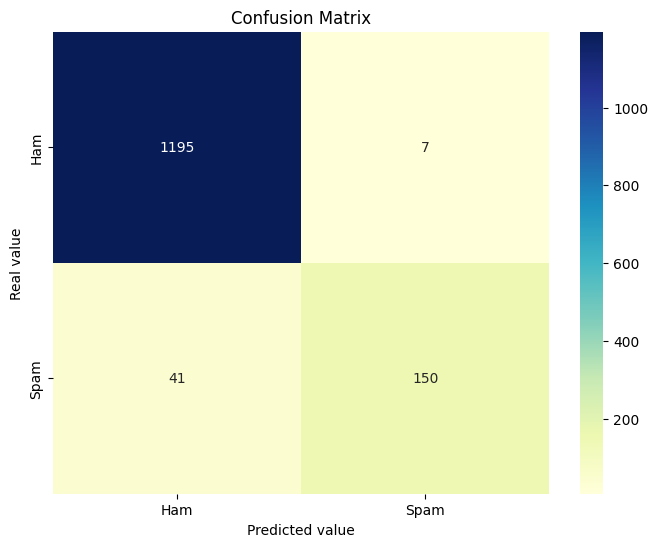

In [ ]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=250,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

pipe.fit(x_train, y_train)
y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train Accuracy is:', metrics.accuracy_score(y_train, y_pred_train))
print('Test Accuracy is:', metrics.accuracy_score(y_test, y_pred_class))

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)

# Create the heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], cbar=True)

# Set the labels and title
plt.xlabel('Predicted value')
plt.ylabel('Real value')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# 7. Deep Learning --> Word Embedding (GloVe) + LSTM

split the pre-processed data: Padded and tokenized "train_padded_sentences"

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [ ]:
length_long_sentence = train_padded_sentences.shape[1]
length_long_sentence

80

In [ ]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    model = Sequential()

    # Embedding Layer with explicit input_shape instead of input_length
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_shape=(length_long_sentence,)  # Updated to input_shape
    ))

    # Bidirectional LSTM with fixed units
    model.add(Bidirectional(LSTM(
        units=length_long_sentence,  # Set units to a specific number
        return_sequences=True,
        recurrent_dropout=0.2
    )))

    # Additional layers: GlobalMaxPool, BatchNormalization, Dropout, and Dense
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize and summarize the model
model = glove_lstm()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 80, 100)             │         672,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 80, 160)             │         115,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 160)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 80)                  │          12,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │           6,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 808,521 (3.08 MB)

 Trainable params: 808,201 (3.08 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.keras',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7781 - loss: 0.4993
Epoch 1: val_loss improved from inf to 0.25677, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 456ms/step - accuracy: 0.7787 - loss: 0.4981 - val_accuracy: 0.9375 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9336 - loss: 0.1903
Epoch 2: val_loss improved from 0.25677 to 0.13477, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 390ms/step - accuracy: 0.9336 - loss: 0.1902 - val_accuracy: 0.9677 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9640 - loss: 0.1156
Epoch 3: val_loss improved from 0.13477 to 0.09692, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 333ms/step - accuracy: 0.9640 - loss: 0.1157 - val_accuracy: 0.9706 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9680

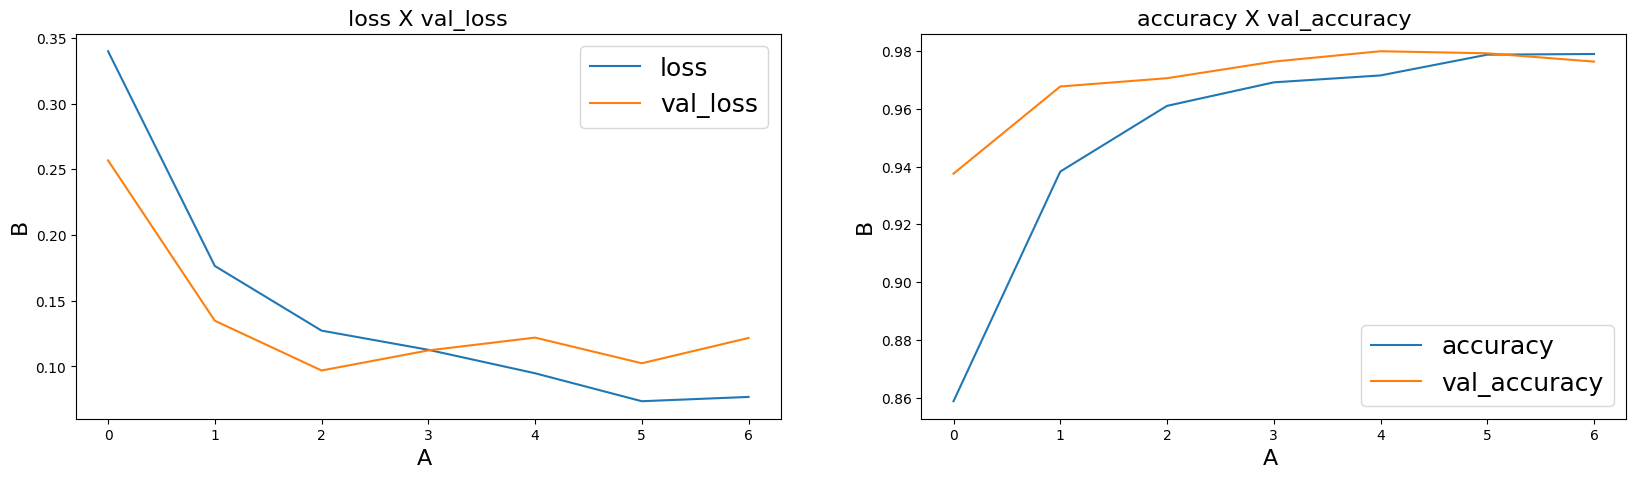

In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

We clearly observe **overfitting**, since training accuracy is improving but the validation accuracy is falling!

Hint: We could easily fix it by increasing learning patience factor :)

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step
The validation accuracy for LSTM + paddedGloVe is:  0.9763101220387652


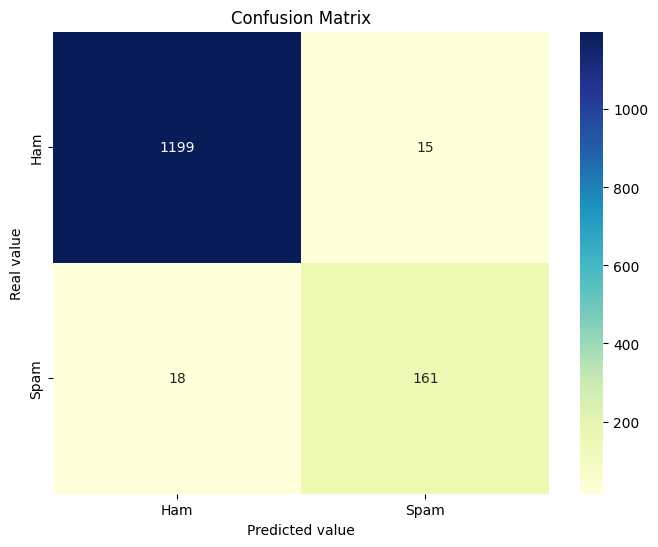

In [ ]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")

print('The validation accuracy for LSTM + paddedGloVe is: ', metrics.accuracy_score(y_test, y_preds))

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Create the heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], cbar=True)

# Set the labels and title
plt.xlabel('Predicted value')
plt.ylabel('Real value')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# 8. Deep Learning --> Word Embedding (GloVe) + GRU

**Explanation:**


1. GRU Model Structure:

* Embedding Layer: Uses GloVe embeddings with a shape determined by embedding_matrix.
* Bidirectional GRU Layer: Replaces LSTM with GRU, using recurrent_dropout to regularize the model.
* GlobalMaxPool1D and Dense Layers: Global max-pooling, batch normalization, dropout, and dense layers are added for further regularization and to create a deeper network.


2. Callbacks:

*  ModelCheckpoint: Saves the best model based on validation loss.
*  ReduceLROnPlateau: Reduces learning rate if no improvement in validation loss, to help with convergence.


3. Training and Evaluation:

* Plots loss and accuracy curves for training and validation using the plot_learning_curves function.
* Evaluates validation accuracy and plots a confusion matrix for better visualization.


**Notes:**

Epochs and Batch Size: Adjust these based on dataset size and model performance.
Embedding Training: Set trainable=True in the embedding layer if you want the model to fine-tune the GloVe embeddings during training.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 80, 100)             │         672,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 80, 160)             │          87,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 160)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 80)                  │          12,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 80)                  │           6,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 780,041 (2.98 MB)

 Trainable params: 107,121 (418.44 KB)

 Non-trainable params: 672,920 (2.57 MB)

Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8184 - loss: 0.4652
Epoch 1: val_loss improved from inf to 0.42248, saving model to gru_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 395ms/step - accuracy: 0.8188 - loss: 0.4644 - val_accuracy: 0.8894 - val_loss: 0.4225 - learning_rate: 0.0010
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9195 - loss: 0.2144
Epoch 2: val_loss improved from 0.42248 to 0.15709, saving model to gru_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 397ms/step - accuracy: 0.9196 - loss: 0.2144 - val_accuracy: 0.9612 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9419 - loss: 0.1787
Epoch 3: val_loss improved from 0.15709 to 0.12731, saving model to gru_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 402ms/step - accuracy: 0.9419 - loss: 0.1788 - val_accuracy: 0.9548 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accu

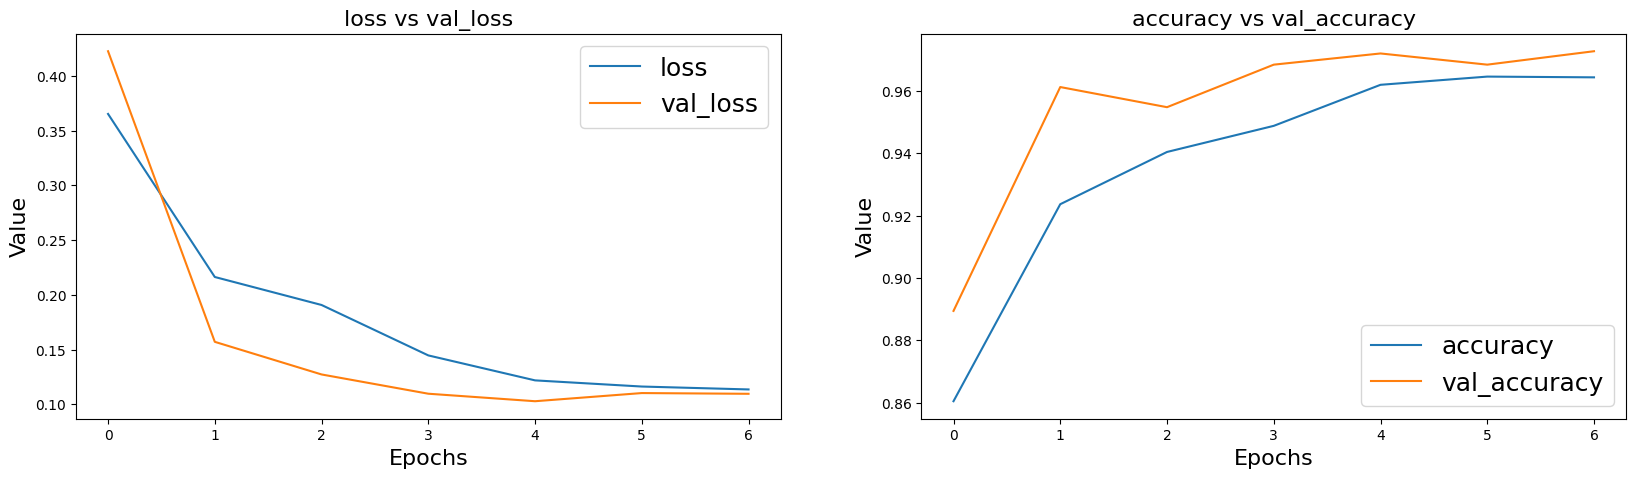

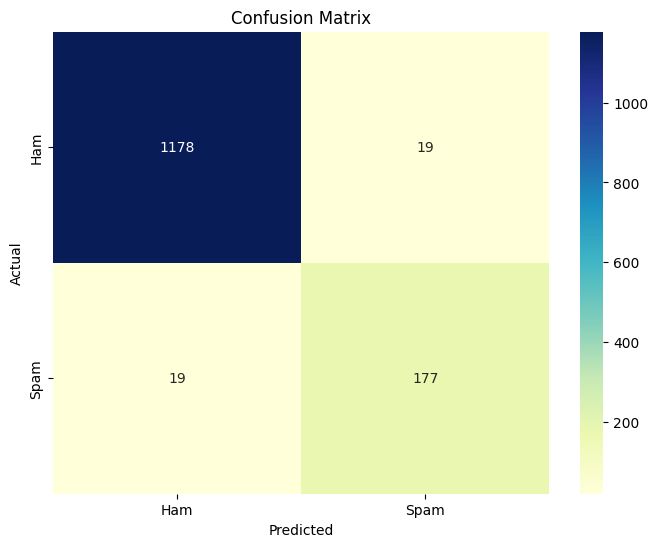

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `train_padded_sentences` is the padded sequence data and `target` is the label
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

# Get the length of the longest sentence (used for model dimensions)
length_long_sentence = train_padded_sentences.shape[1]

# GRU Model using GloVe embeddings
def glove_gru():
    model = Sequential()

    # Embedding Layer with explicit input_shape
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_shape=(length_long_sentence,),
        trainable=False  # Optionally, set trainable=True if you want to fine-tune embeddings
    ))

    # Bidirectional GRU layer
    model.add(Bidirectional(GRU(
        units=length_long_sentence,
        return_sequences=True,
        recurrent_dropout=0.2
    )))

    # Additional layers
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize and summarize the model
model = glove_gru()
model.summary()

# Training with callbacks
checkpoint = ModelCheckpoint(
    'gru_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.001
)

history = model.fit(
    X_train,
    y_train,
    epochs=7,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, checkpoint]
)

# Plot Learning Curves
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]], fontsize=18)
        ax[idx].set_xlabel('Epochs', fontsize=16)
        ax[idx].set_ylabel('Value', fontsize=16)
        ax[idx].set_title(f'{arr[idx][0]} vs {arr[idx][1]}', fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

# Model predictions and evaluation
y_preds = (model.predict(X_test) > 0.5).astype("int32")
print('The validation accuracy for GRU + GloVe is:', metrics.accuracy_score(y_test, y_preds))

# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
